In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [189]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [190]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/4plex/output_data/final_dilutions.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data = main_data[['patient_id', 'time_point_days', 'HRP2_pg_ml',
                       'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml', 'HRP2_pg_ml_dilution',
                       'HRP2_pg_ml_max_dilution', 'day0_enrollee',
                       'days_since_tx', 'initial_sample', 'got_PQ', 'age',
                       'sex', 'fever48_r', 'enrolled_from',
                       'returned_with_fever', 'when_returned_with_fever',
                       'retreated', 'when_retreated']]
main_data.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  \
0     pa-001                3   318702.59         142.30         15.35   
1     pa-001                7    73737.79         179.34         10.31   
2     pa-001               14     4138.79          14.41          2.76   
3     pa-001               21     1377.18          38.94         12.21   
4     pa-001               28     2024.41          29.86         13.90   

   CRP_ng_ml  HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  \
0    5678.58                 2500                312500000            1.0   
1    1021.09                 2500                   125000            1.0   
2    7064.05                   50                       50            1.0   
3    2413.65                   50                       50            1.0   
4      92.87                   50                       50            1.0   

   days_since_tx  initial_sample  got_PQ  age     sex  fever48_r  \
0            3.0             NaN     1.0    2  female        1.0   
1            9.0             NaN     1.0    2  female        1.0   
2           17.0             NaN     1.0    2  female        1.0   
3           23.0             NaN     1.0    2  female        1.0   
4            NaN             NaN     1.0    2  female        1.0   

     enrolled_from  returned_with_fever when_returned_with_fever  retreated  \
0  health facility                  NaN                      NaN        NaN   
1  health facility                  NaN                      NaN        NaN   
2  health facility                  NaN                      NaN        NaN   
3  health facility                  NaN                      NaN        NaN   
4  health facility                  NaN                      NaN        NaN   

   when_retreated  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [191]:
rebuilt_data = []
for pid in main_data['patient_id'].unique():
    sub_data = main_data.loc[main_data['patient_id'] == pid]
    if len(sub_data) < 4:
        continue
    all_times = sub_data['time_point_days'].unique().tolist()
    start_val = sub_data.loc[sub_data['time_point_days'] == min(all_times), 'HRP2_pg_ml'].item()
    if start_val < 10:
        continue
    rebuilt_data.append(sub_data)
rebuilt_data = pd.concat(rebuilt_data)
rebuilt_data[val_cols] = rebuilt_data[val_cols].applymap(np.log10)
rebuilt_data.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  \
0     pa-001                3    5.503386       2.153205      1.186108   
1     pa-001                7    4.867690       2.253677      1.013259   
2     pa-001               14    3.616873       1.158664      0.440909   
3     pa-001               21    3.138991       1.590396      1.086716   
4     pa-001               28    3.306298       1.475090      1.143015   

   CRP_ng_ml  HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  \
0   3.754240                 2500                312500000            1.0   
1   3.009064                 2500                   125000            1.0   
2   3.849054                   50                       50            1.0   
3   3.382674                   50                       50            1.0   
4   1.967875                   50                       50            1.0   

   days_since_tx  initial_sample  got_PQ  age     sex  fever48_r  \
0            3.0             NaN     1.0    2  female        1.0   
1            9.0             NaN     1.0    2  female        1.0   
2           17.0             NaN     1.0    2  female        1.0   
3           23.0             NaN     1.0    2  female        1.0   
4            NaN             NaN     1.0    2  female        1.0   

     enrolled_from  returned_with_fever when_returned_with_fever  retreated  \
0  health facility                  NaN                      NaN        NaN   
1  health facility                  NaN                      NaN        NaN   
2  health facility                  NaN                      NaN        NaN   
3  health facility                  NaN                      NaN        NaN   
4  health facility                  NaN                      NaN        NaN   

   when_retreated  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [192]:
analyte_name_dict = {'HRP2_pg_ml': ('HRP2', 'pg/ml'), 'LDH_Pan_pg_ml': ('LDH_Pan', 'pg/ml'),
                     'LDH_Pv_pg_ml': ('LDH_Pv', 'pg/ml'), 'CRP_ng_ml': ('CRP', 'ng/ml')}
group_infection_dict = {'red': 'symptomatic', 'yellow': 'chronic', 'green': 'clearing',
                        'blue': 'uninfected', 'black': 'uncategorized'}

In [193]:
def get_coef(df):
    regr = linear_model.LinearRegression()
    time = df['time_point_days'].values.reshape(-1,1)
    val = df['HRP2_pg_ml'].values.reshape(-1,1)
    regr.fit(time, val)
    coef = np.float(regr.coef_)
    pred = regr.predict(time)
    score = r2_score(val, pred)
    return coef

In [194]:
problem_pids = ['pa-017', 'pa-020', 'pa-026', 'pa-035', 'pa-049',
                'pa-072', 'pa-077', 'pa-109', 'pa-113', 'pa-114',
                'pa-124', 'pa-129', 'pa-140', 'pa-149', 'pa-169']

In [195]:
# first outlier points

In [196]:
all_dfs = []
# loop through patients
for pid in rebuilt_data['patient_id'].unique():
# for pid in problem_pids:
# for pid in ['pa-149']:
    # subset data to just PID of interest
    pid_data = rebuilt_data.loc[rebuilt_data['patient_id'] == pid]
    # fetch and sort day values
    all_times = pid_data['time_point_days'].unique().tolist()
    all_times.sort()
    # get first three days
    first_days = all_times[:3]
    # get other times
    later_days = all_times[3:]
    # get initial HRP2 value
    initial_pg = pid_data.loc[pid_data['time_point_days'] == first_days[0], 'HRP2_pg_ml'].item()
    # subset a dataframe of just the first three days
    early_df = pid_data.loc[pid_data['time_point_days'].isin(first_days)]
    # get the mean of the first three HRP2 values
    mean_val = early_df['HRP2_pg_ml'].mean()
    # subset a dataframe to all the other days
    other_df = pid_data.loc[~pid_data['time_point_days'].isin(first_days)]
    # start the outliering here
    i = 3
    outlier_vals = []
    while i <= len(later_days) + 1:
        try:
            time_vals = all_times[i-1:i+2]
            num_days = 3
        except IndexError:
            time_vals = all_times[i-1:i]
            num_days = 2
        prev_val = pid_data.loc[pid_data['time_point_days'] == time_vals[0], 'HRP2_pg_ml'].item()
        day_val = pid_data.loc[pid_data['time_point_days'] == time_vals[1], 'HRP2_pg_ml'].item()
        if num_days == 3:
            next_val = pid_data.loc[pid_data['time_point_days'] == time_vals[2], 'HRP2_pg_ml'].item()
            cond_a = ((day_val - prev_val) > 1.5) & ((day_val - next_val) > 1.5)
            cond_b = ((prev_val - day_val) > 1.5) & ((next_val - day_val) > 1.5)
            if cond_a or cond_b:
                outlier_vals.append(time_vals[1])
        else:
            if (abs(day_val - prev_val) > 2):
                outlier_vals.append(time_vals[1])
        i += 1
    outliered_df = pid_data.loc[~pid_data['time_point_days'].isin(outlier_vals)]
    all_dfs.append(outliered_df)
outliered = pd.concat(all_dfs)

In [197]:
# then group points

In [198]:
all_dfs = []
# loop through patients
for pid in outliered['patient_id'].unique():
# for pid in problem_pids:
# for pid in ['pa-020']:
    # subset data to just PID of interest
    pid_data = outliered.loc[outliered['patient_id'] == pid]
    # fetch and sort day values
    all_times = pid_data['time_point_days'].unique().tolist()
    all_times.sort()
    # get first three days
    first_days = all_times[:3]
    # get other times
    later_days = all_times[3:]
    # get initial HRP2 value
    initial_pg = pid_data.loc[pid_data['time_point_days'] == first_days[0], 'HRP2_pg_ml'].item()
    # subset a dataframe of just the first three days
    early_df = pid_data.loc[pid_data['time_point_days'].isin(first_days)]
    # second and third points must be clearing (green)
    early_df['group'] = 'green'
    # first point must be one of either symptomatic (red) or chronic (yellow)
    first_fever = pid_data['fever48_r'].unique()[0]
    if first_fever == 1:
        early_df.loc[early_df['time_point_days'] == first_days[0], 'group'] = 'red'
    else:
        early_df.loc[early_df['time_point_days'] == first_days[0], 'group'] = 'yellow'
    # get the mean of the first three HRP2 values
    mean_val = early_df['HRP2_pg_ml'].mean()
    # subset a dataframe to all the other days
    other_df = pid_data.loc[~pid_data['time_point_days'].isin(first_days)]
    # set to clearing as a base line
    other_df['group'] = 'green'
    # get the date of retreatment if it exists
    when_retreated = other_df['when_retreated'].unique()[0]
    # start the complex grouping here!
    the_rest = []
    i = 0
    end_val = 4
    max_run = 4
    chronic_vals = []
    longest_section = []
    set_all = False
    if first_fever != 1:
        final_pg = pid_data.loc[pid_data['time_point_days'] == later_days[-1], 'HRP2_pg_ml'].item()
        if (final_pg > 2.9) or ((initial_pg - final_pg) < 1):
            set_all = True
    while (end_val < len(all_times)) & (len(the_rest) != 1):
        time_vals = later_days[i:end_val]
        small_df = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
        try:
            coef_a = get_coef(small_df)
        except:
            bad_df = small_df
            print('len(all_times): {}'.format(len(all_times)))
            print('the_rest: {}'.format(the_rest))
            raise
        while (coef_a > -.02) & (len(time_vals) != 1) & (end_val < len(all_times)):
            end_val = end_val + 1
            time_vals = later_days[i:end_val]
            bigger_df = pid_data.loc[pid_data['time_point_days'].isin(time_vals)]
            coef_b = get_coef(bigger_df)
            if coef_b > -.01:
                final_4 = time_vals[-4:]
                check_df = pid_data.loc[pid_data['time_point_days'].isin(final_4)]
                coef_c = get_coef(check_df)
                if coef_c > -.05:
                    current_run = len(time_vals)
                    if current_run > max_run:
                        max_run = current_run
                        longest_section = time_vals[:-1]
                        chronic_vals += longest_section
        i = end_val - 1
        try:
            all_times[i + 4]
            end_val = i + 4
        except IndexError:
            the_rest = all_times[i:]
            end_val = i + len(the_rest)
    chronic_vals = list(set(chronic_vals))
    chronic_df = other_df.loc[other_df['time_point_days'].isin(chronic_vals)]
    other_df = other_df.loc[~other_df['time_point_days'].isin(chronic_vals)]
    chronic_df['group'] = 'yellow'
    chronic_df.loc[chronic_df['HRP2_pg_ml'] < 1.5, 'group'] = 'green'
    other_df = pd.concat([other_df, chronic_df])
    combined = pd.concat([early_df, other_df])
    if set_all:
        combined['group'] = 'yellow'
    if when_retreated is not None:
        if pid != 'pa-026': #patient 26 doesn't make sense and was treated after the study ended, which breaks everything
            combined.loc[combined['time_point_days'] == when_retreated, 'group'] = 'red'
            before_retreat = combined.loc[combined['time_point_days'] < when_retreated]
            before_retreat.loc[before_retreat['group'] == 'green', 'group'] = 'yellow'
            before_days = before_retreat['time_point_days'].unique().tolist()
            combined = combined.loc[~combined['time_point_days'].isin(before_days)]
            combined = pd.concat([before_retreat, combined])
    all_dfs.append(combined)
combined = pd.concat(all_dfs)

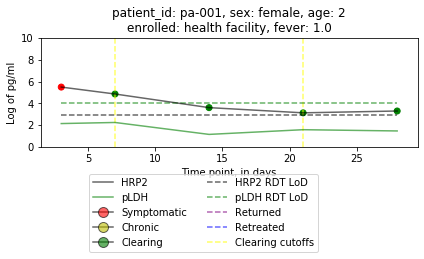

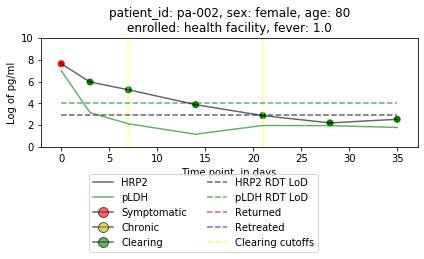

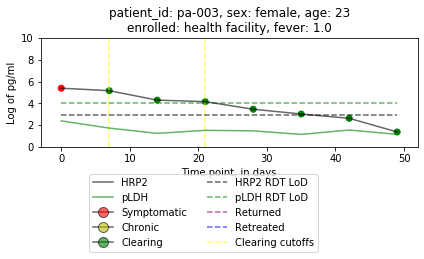

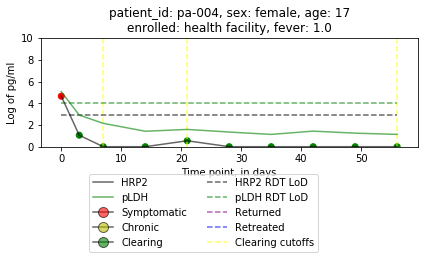

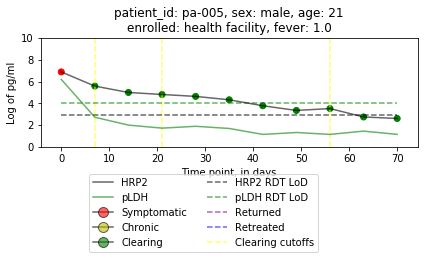

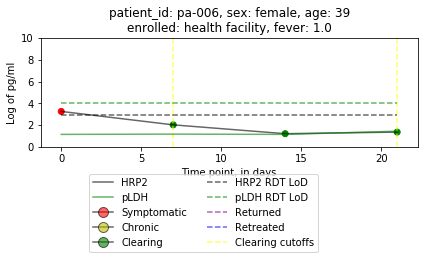

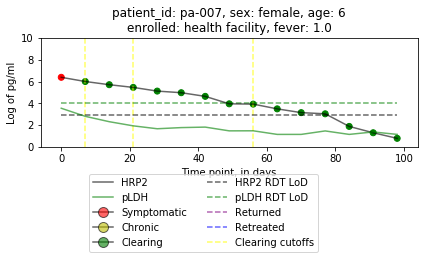

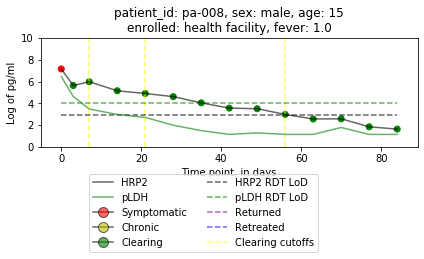

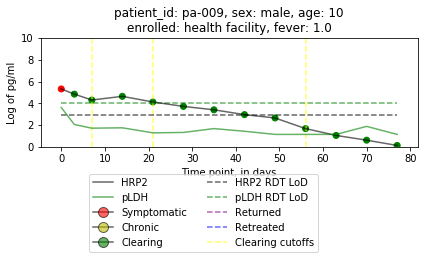

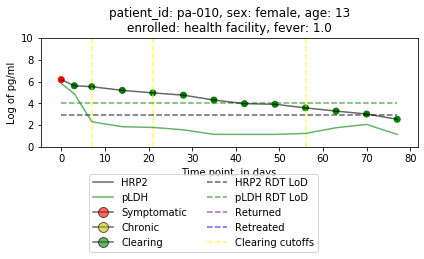

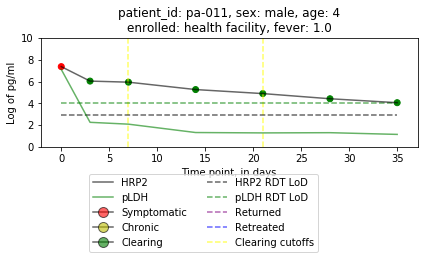

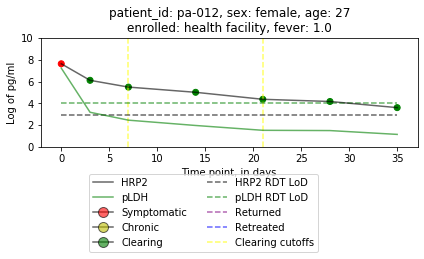

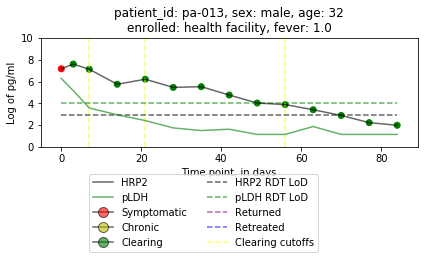

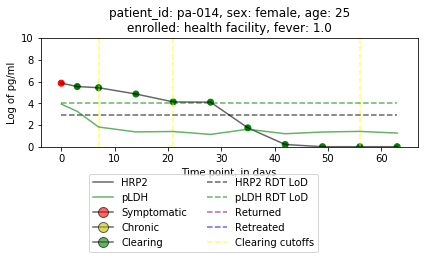

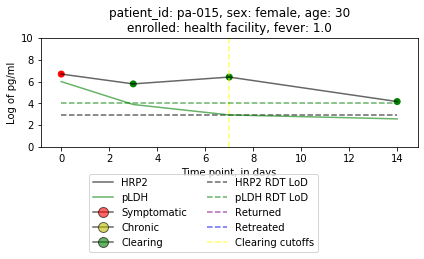

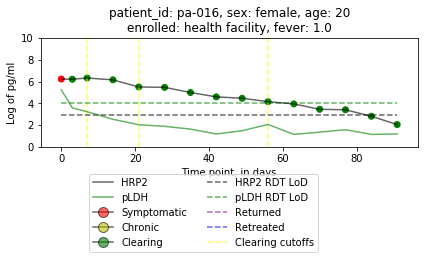

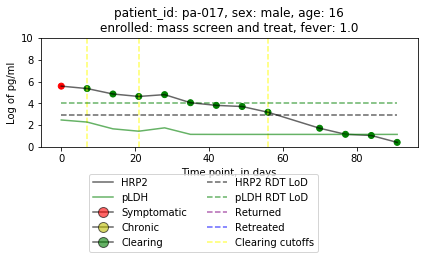

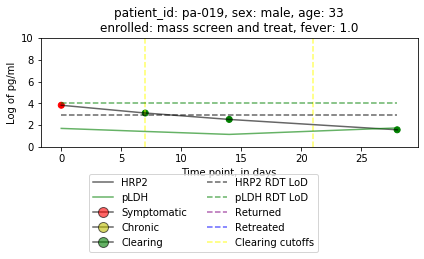

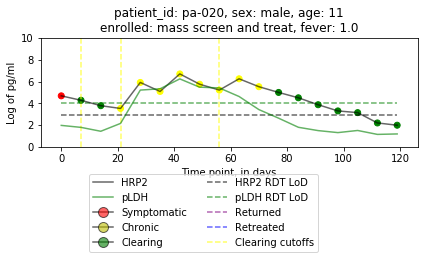

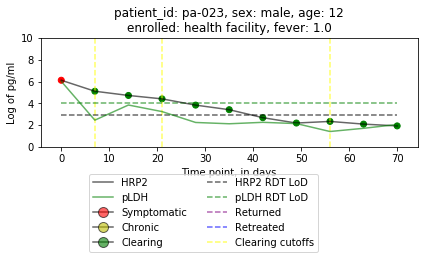

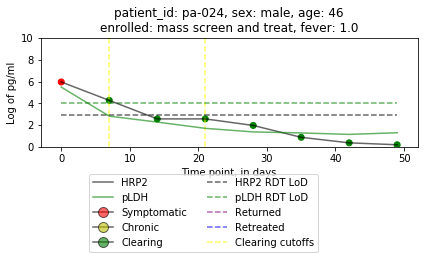

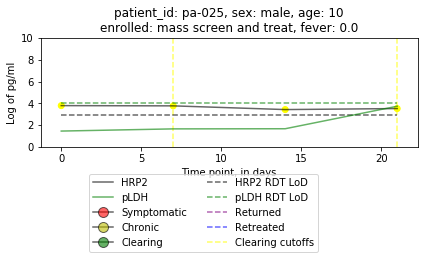

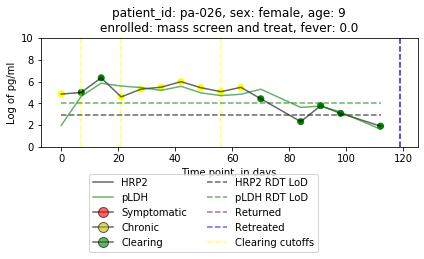

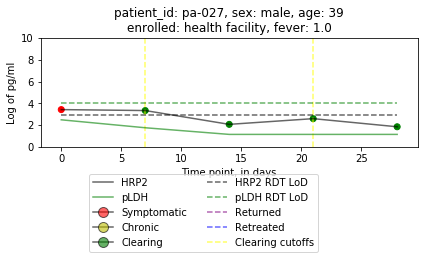

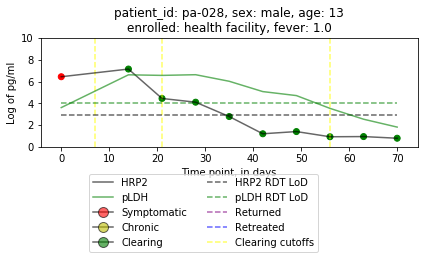

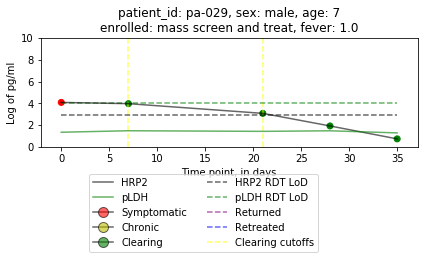

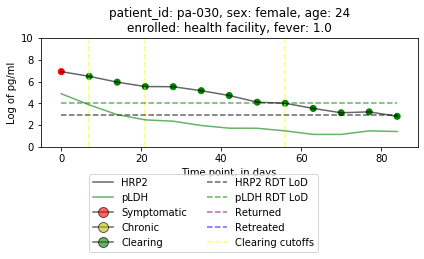

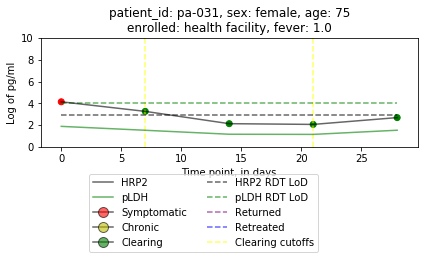

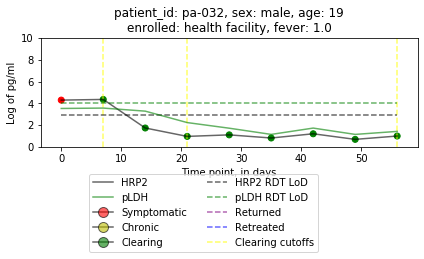

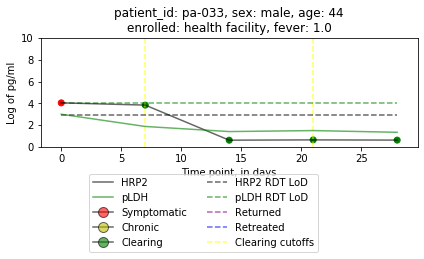

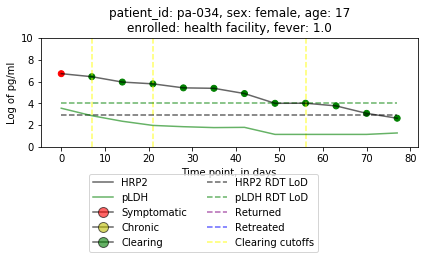

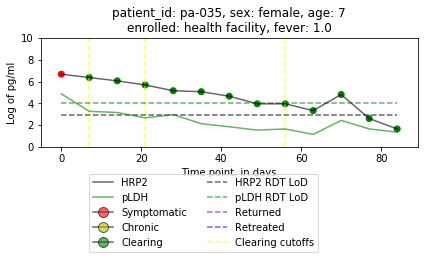

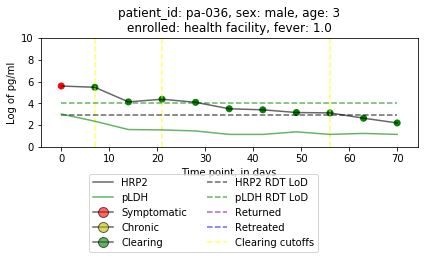

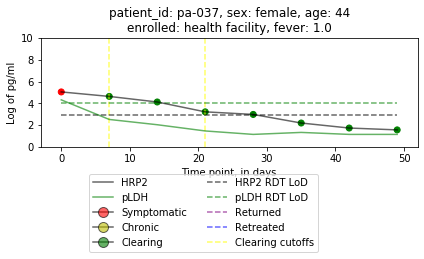

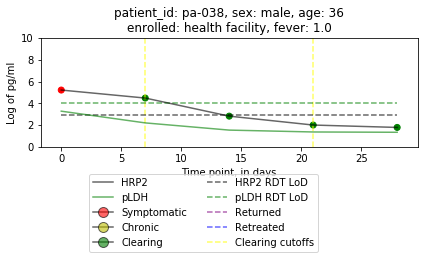

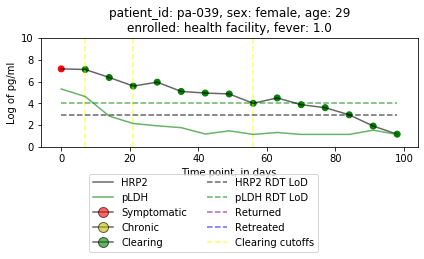

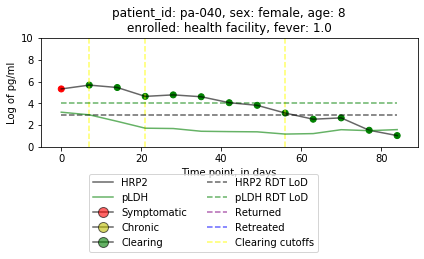

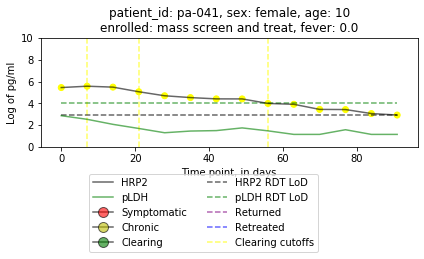

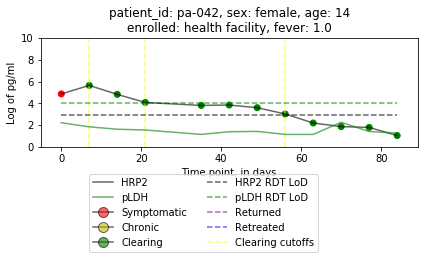

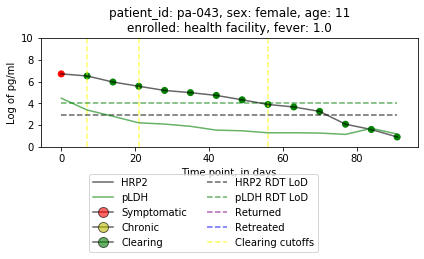

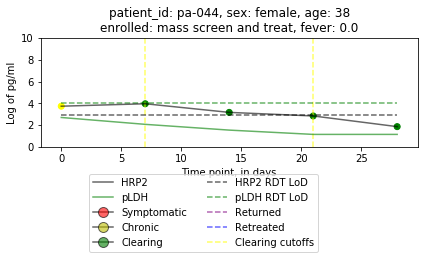

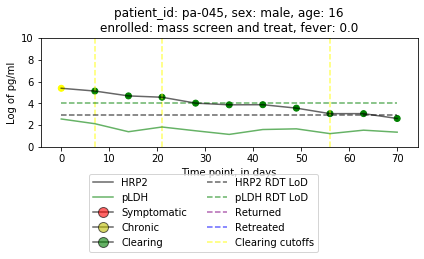

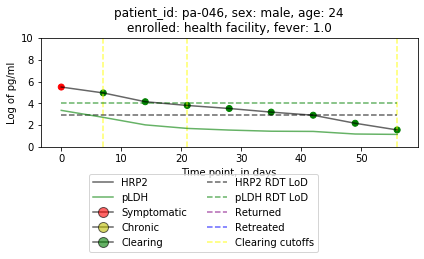

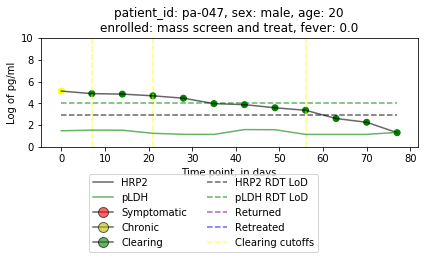

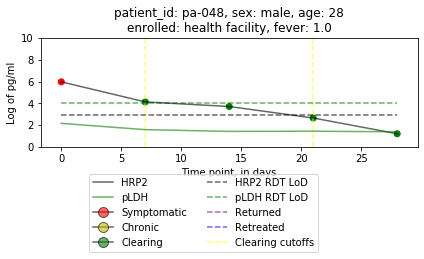

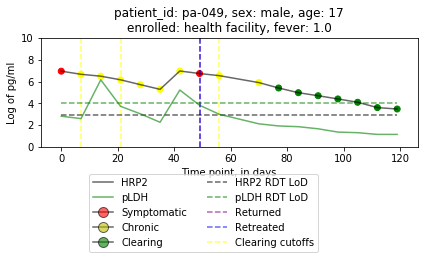

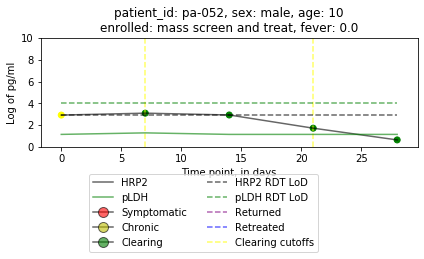

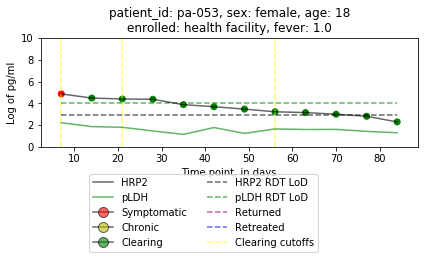

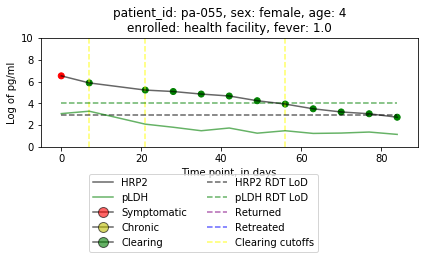

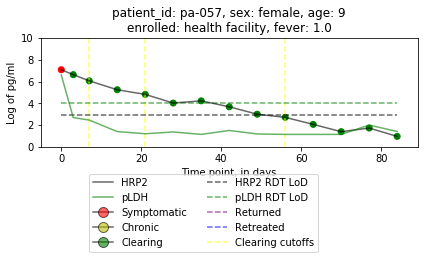

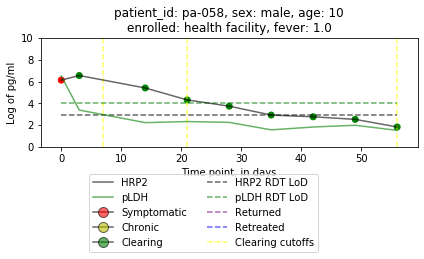

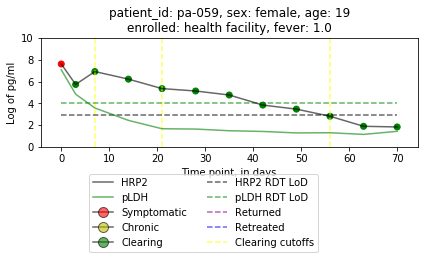

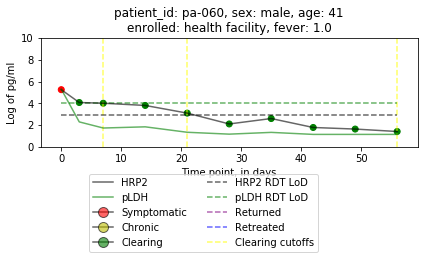

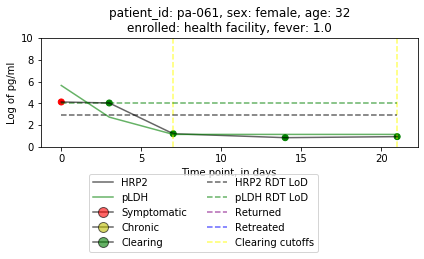

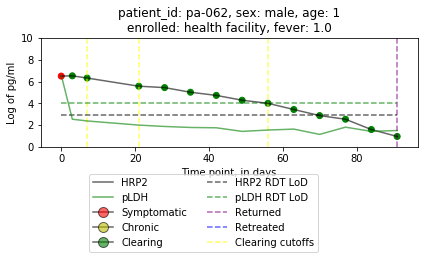

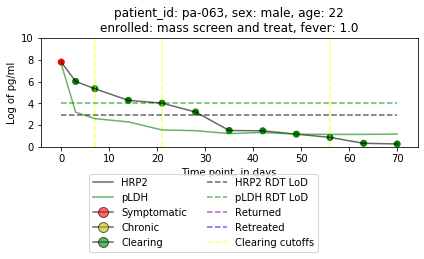

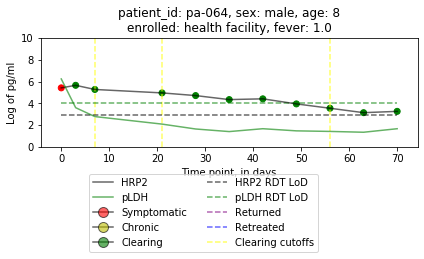

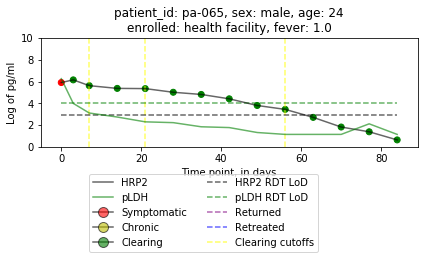

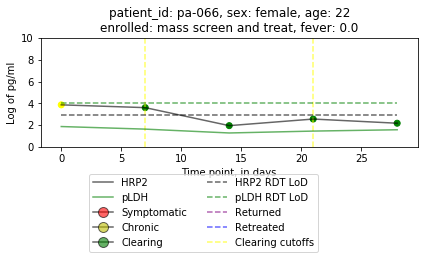

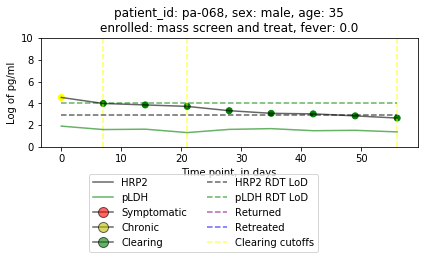

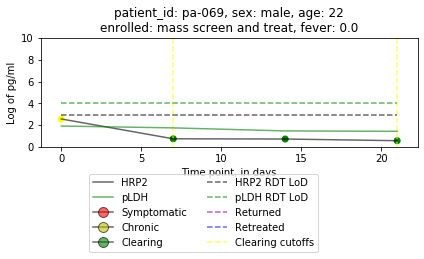

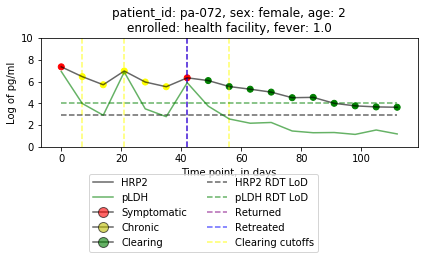

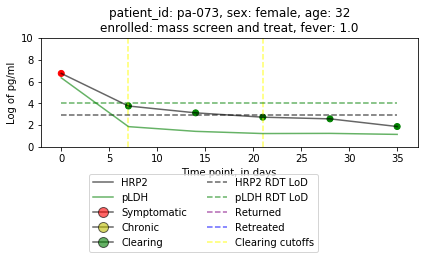

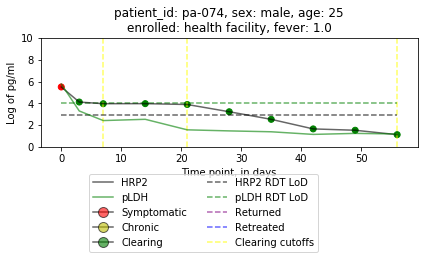

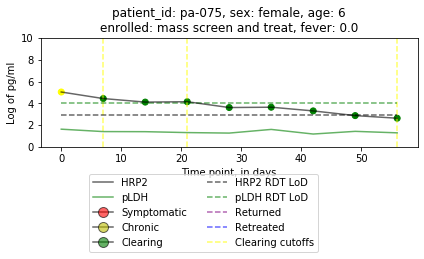

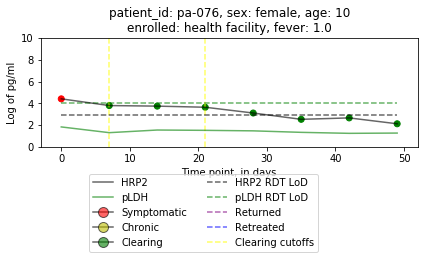

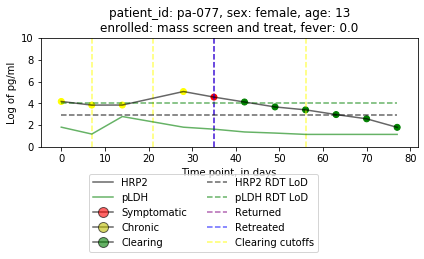

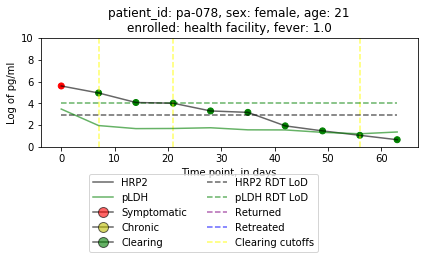

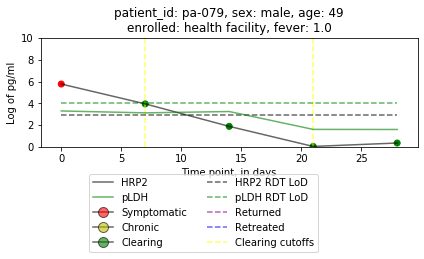

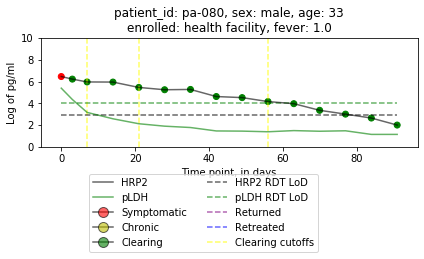

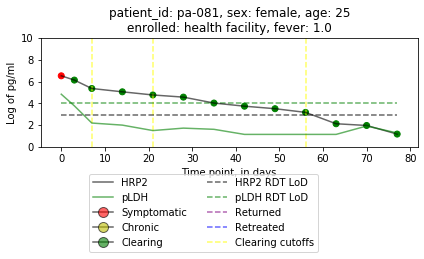

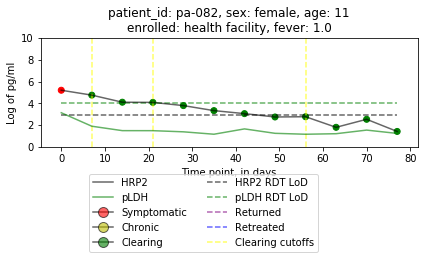

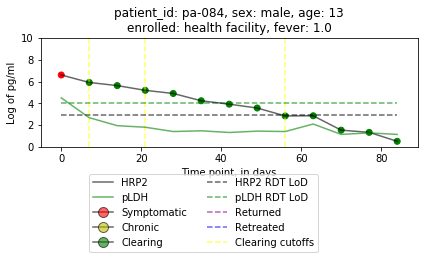

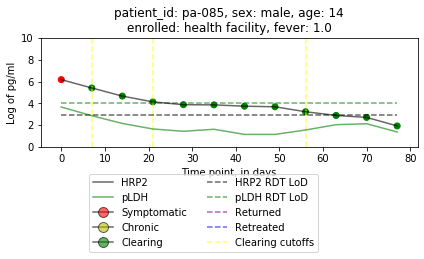

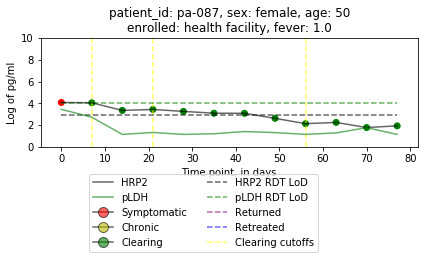

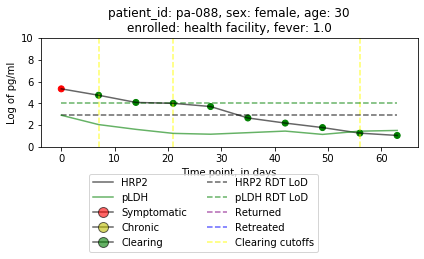

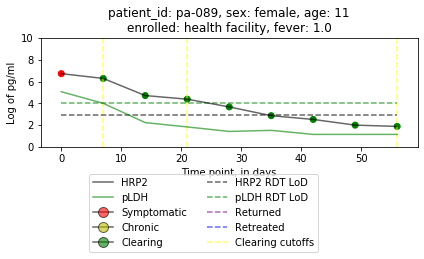

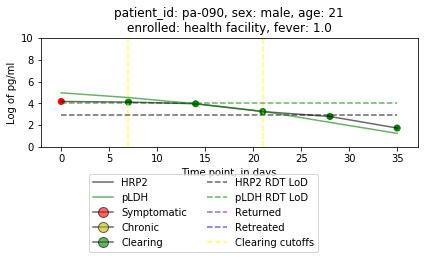

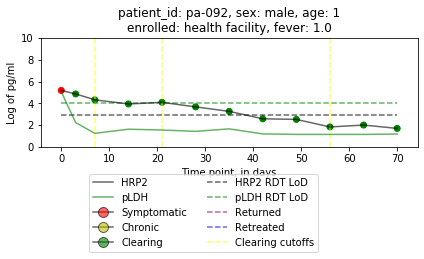

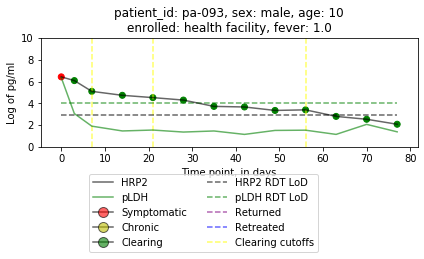

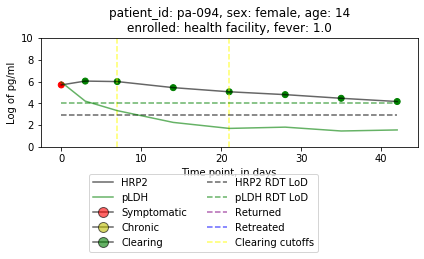

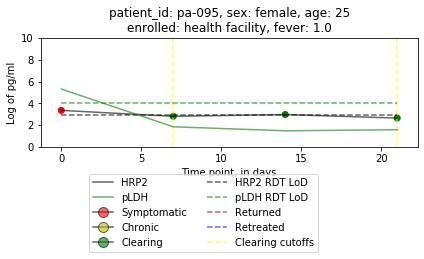

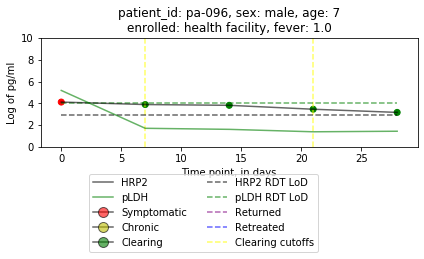

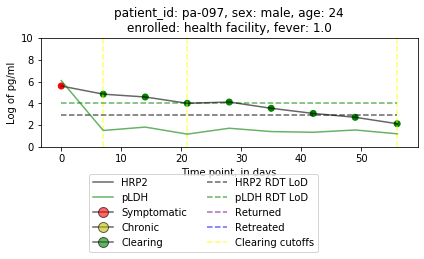

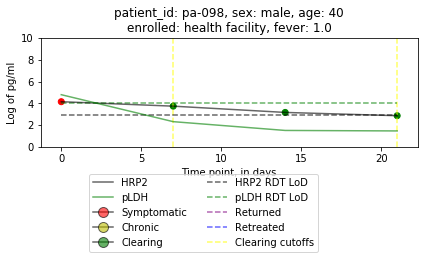

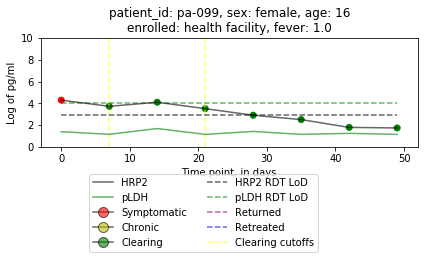

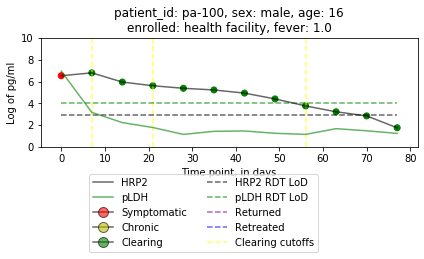

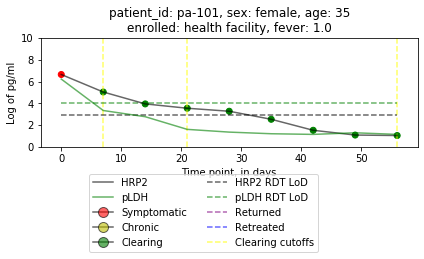

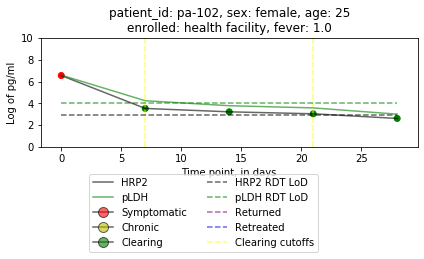

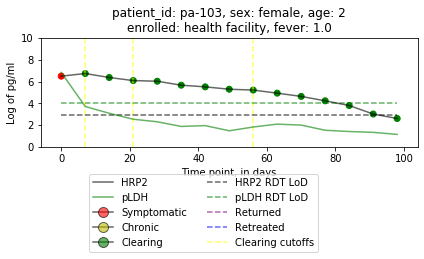

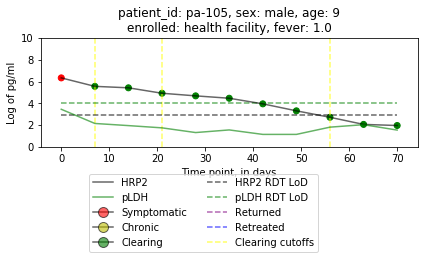

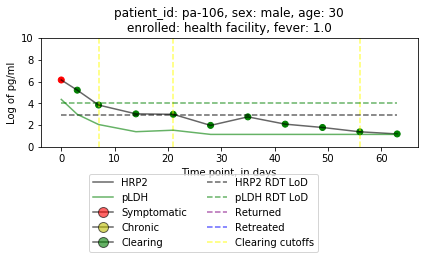

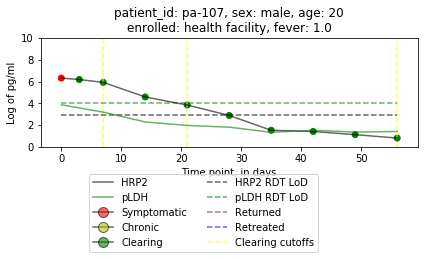

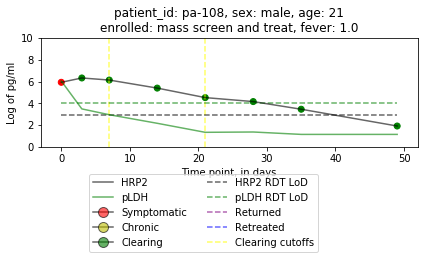

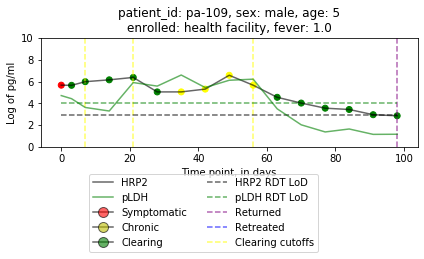

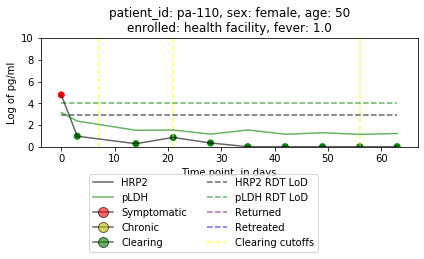

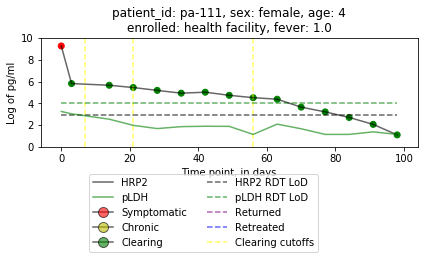

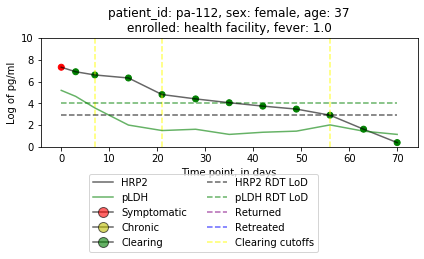

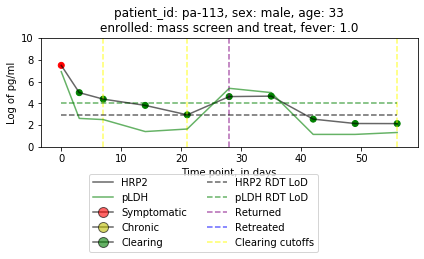

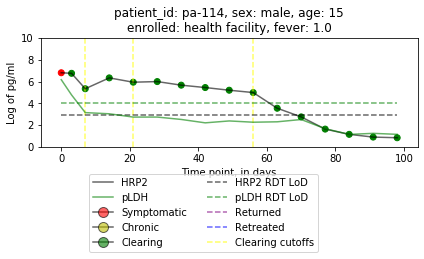

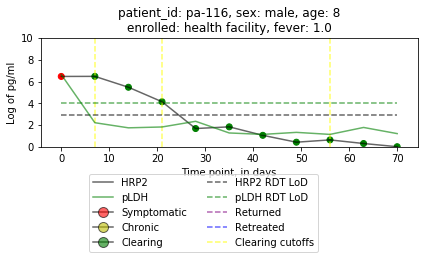

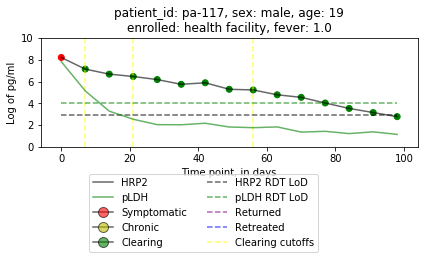

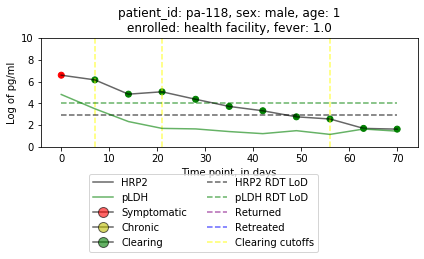

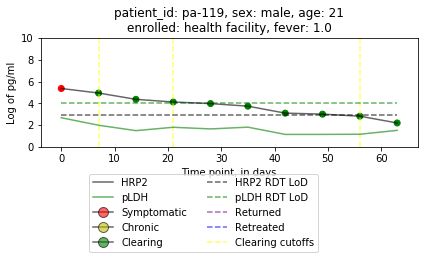

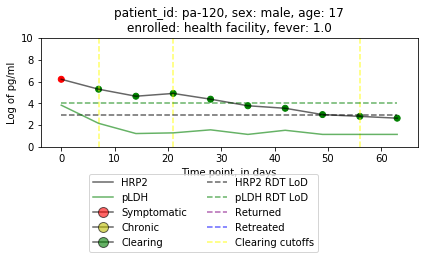

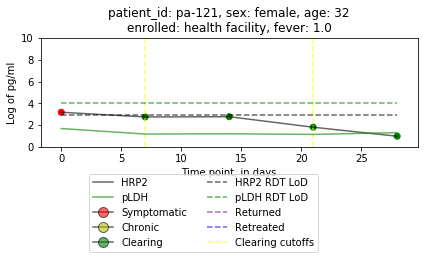

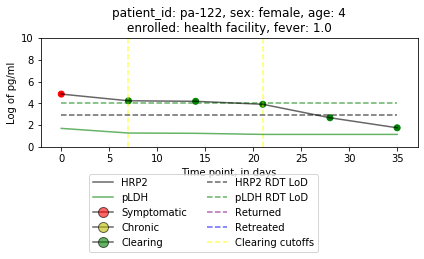

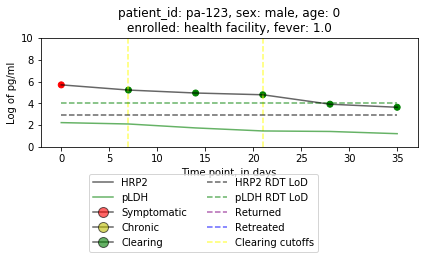

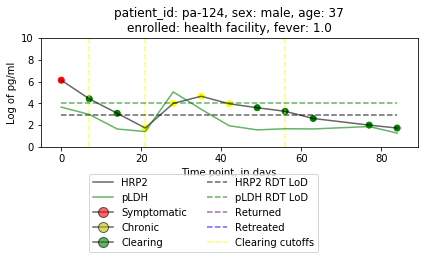

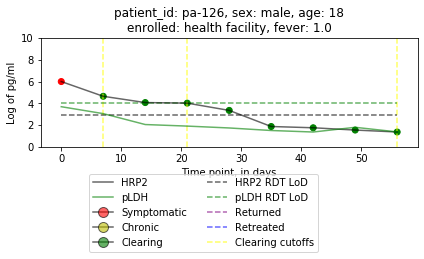

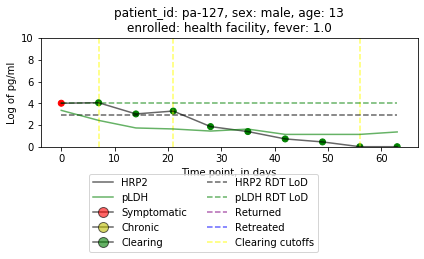

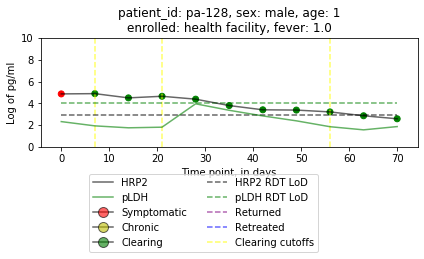

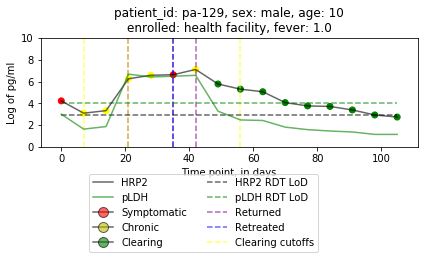

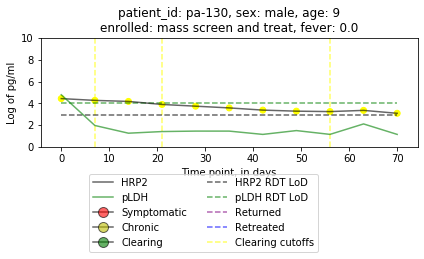

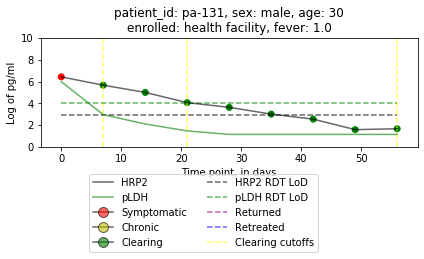

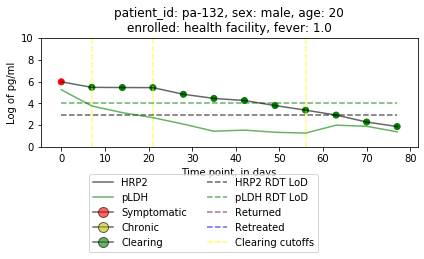

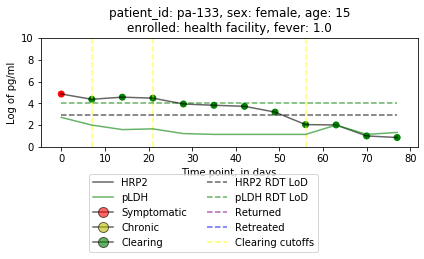

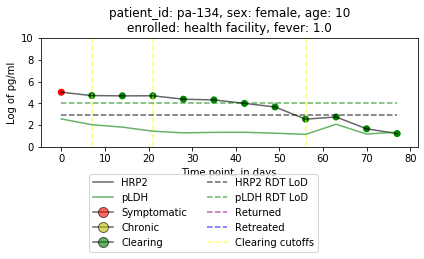

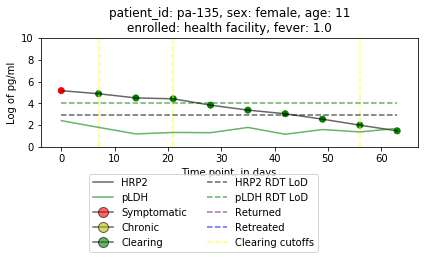

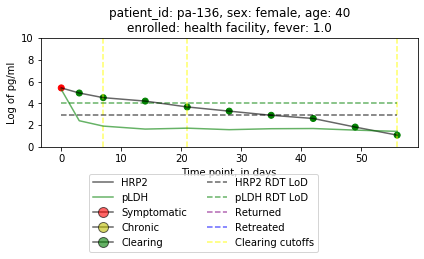

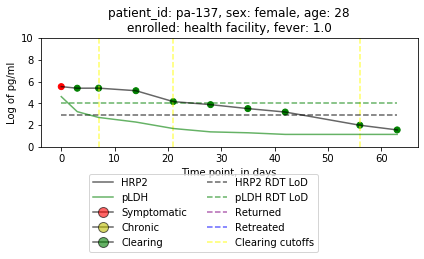

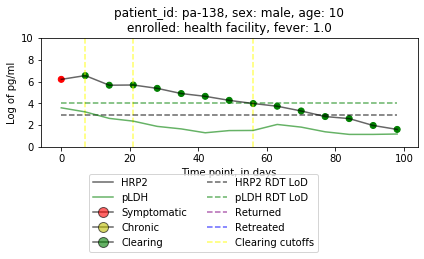

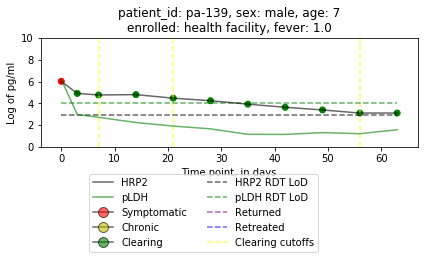

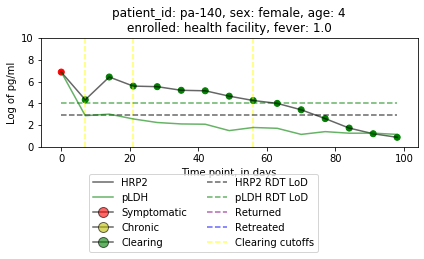

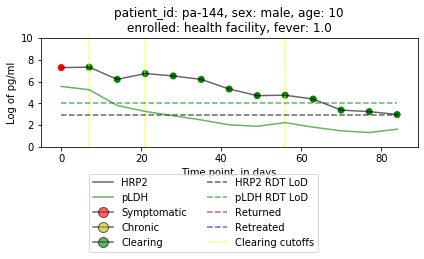

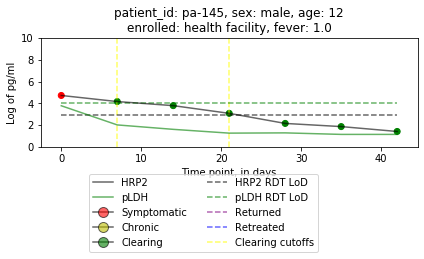

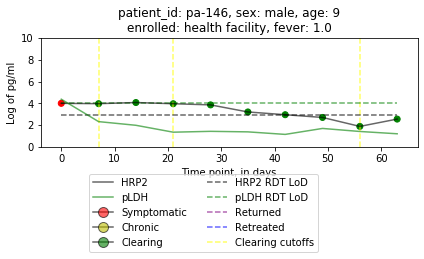

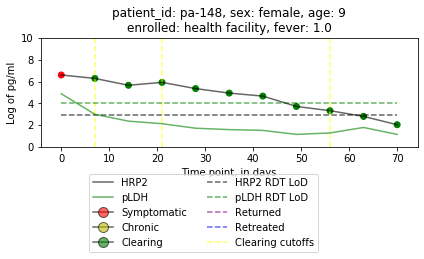

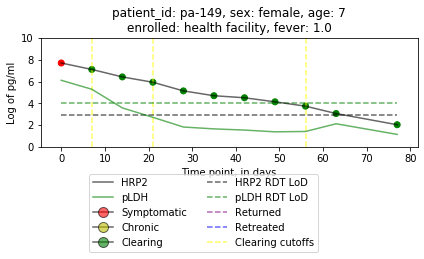

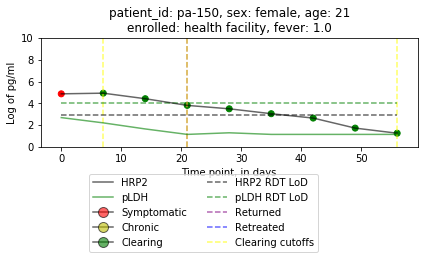

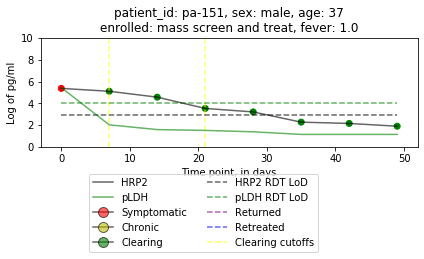

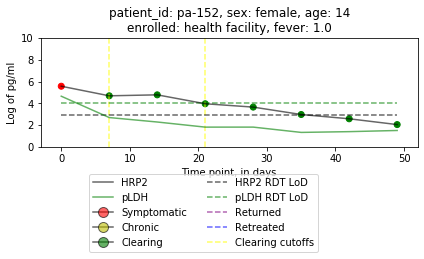

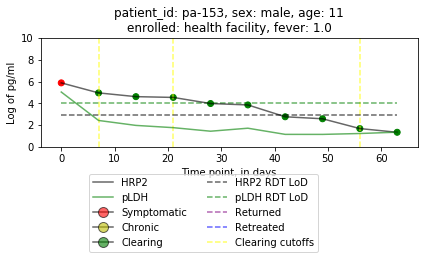

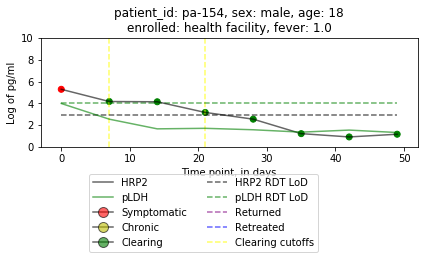

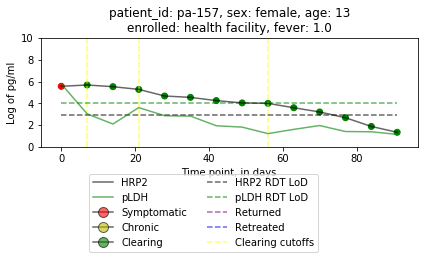

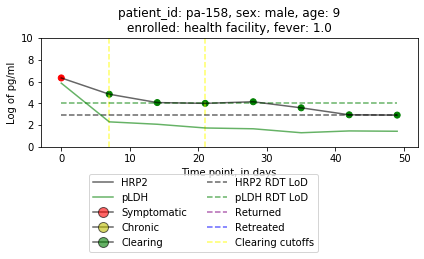

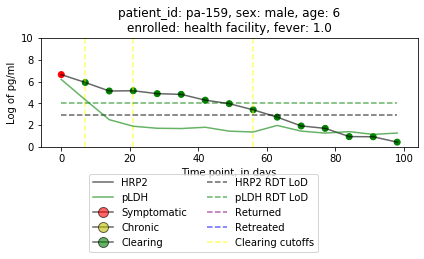

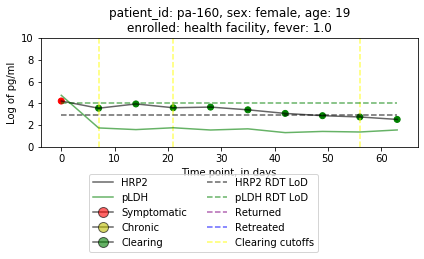

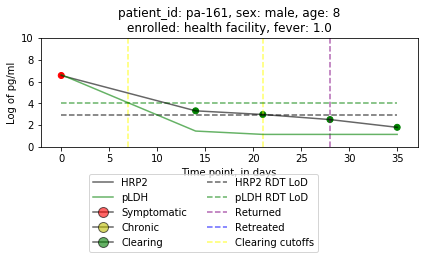

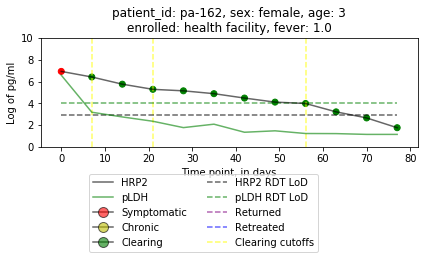

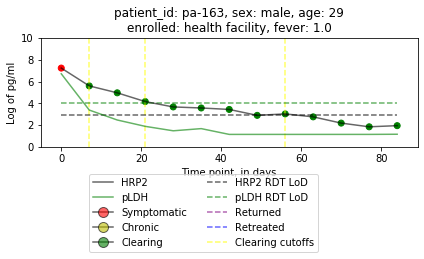

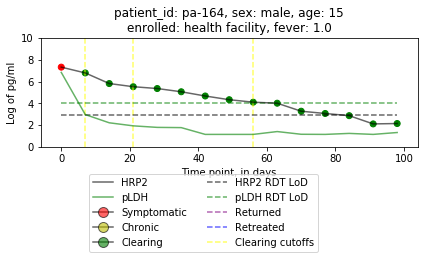

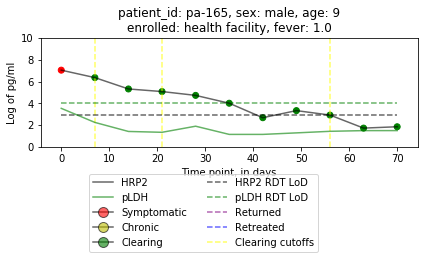

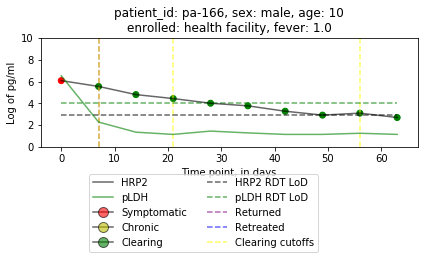

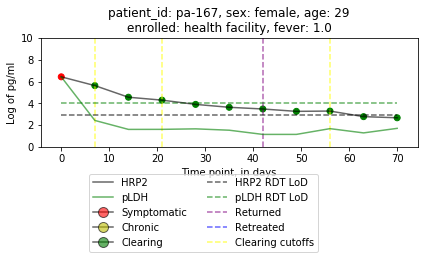

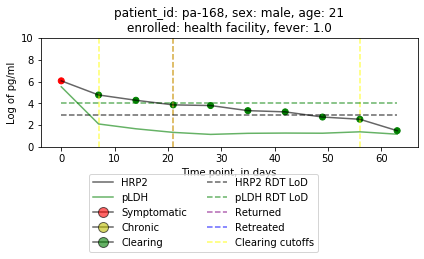

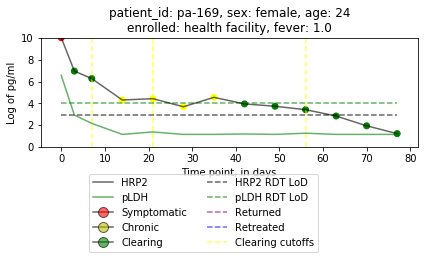

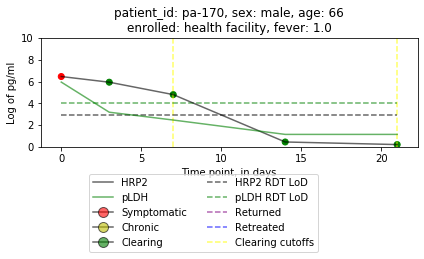

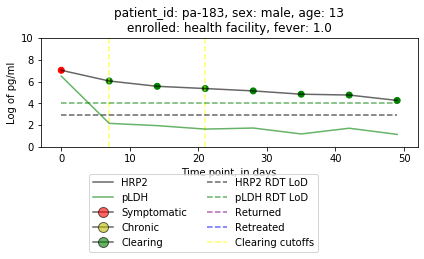

In [199]:
complex_pdf = PdfPages('C:/Users/lzoeckler/Desktop/outliered_complex_grouping.pdf')
for pid in combined['patient_id'].unique():
# for pid in problem_pids:
# for pid in ['pa-020']:
    combo = combined.loc[combined['patient_id'] == pid]
    combo = combo.sort_values('time_point_days')
    max_day = max(combo['time_point_days'])
    min_day = min(combo['time_point_days'])
    max_y = max([max(combo['HRP2_pg_ml']), max(combo['LDH_Pan_pg_ml'])])
    min_y = min([min(combo['HRP2_pg_ml']), min(combo['LDH_Pan_pg_ml'])])
    f, ax1 = plt.subplots()
    sex = combo['sex'].unique()[0]
    age = combo['age'].unique()[0]
    returned = combo['returned_with_fever'].unique()[0]
    when_returned = combo['when_returned_with_fever'].unique()[0]
    enrolled_from = combo['enrolled_from'].unique()[0]
    fever = combo['fever48_r'].unique()[0]
    try:
        treatment_day = combo.loc[combo['days_since_tx'] == 0, 'time_point_days'].item()
    except ValueError:
        treatment_day = None
    if isinstance(when_returned, str):
        try:
            cleaned = [int(when_returned)]
        except ValueError:
            cleaned = when_returned.replace('and ', '')
            cleaned = cleaned.replace(' ', '')
            cleaned = [int(x) for x in cleaned.split(',')]
    else:
        cleaned = []
    retreated = combo['retreated'].unique()[0]
    when_retreated = combo['when_retreated'].unique()[0]
    for when_returned in cleaned:
        return_line = ax1.plot(np.array([when_returned, when_returned]), np.array([0, 10]),
                       color='purple', linestyle='--', alpha=0.6)
    if ~np.isnan(when_retreated):
        when_retreated = int(when_retreated)
        retreat_line = ax1.plot(np.array([when_retreated, when_retreated]), np.array([0, 10]),
                       color='blue', linestyle='--', alpha=0.6)
    day_7 = ax1.plot(np.array([7, 7]), np.array([0, 10]), color='yellow',
                              linestyle='--', alpha=0.6)
    if max_day >= 21:
        day_21 = ax1.plot(np.array([21, 21]), np.array([0, 10]), color='yellow',
                                   linestyle='--', alpha=0.6)
        if max_day >= 56:
            day_56 = ax1.plot(np.array([56, 56]), np.array([0, 10]), color='yellow',
                                       linestyle='--', alpha=0.6)
    hrp2_lod = ax1.plot(np.array([min_day, max_day]), np.array([2.9, 2.9]),
                        color='black', linestyle='--', alpha=0.6)
    pldh_lod = ax1.plot(np.array([min_day, max_day]), np.array([4, 4]),
                        color='green', linestyle='--', alpha=0.6)
    title = """patient_id: {}, sex: {}, age: {}\nenrolled: {}, fever: {}""".format(
        pid, sex, age, enrolled_from, fever)
    ln4 = ax1.plot(combo['time_point_days'], combo['HRP2_pg_ml'],
                   c='black', alpha=0.6, label='HRP2')
    ln3 = ax1.plot(combo['time_point_days'], combo['LDH_Pan_pg_ml'], c='green', alpha=0.6,
                   label='pLDH')
    ax1.scatter(combo['time_point_days'], combo['HRP2_pg_ml'],
                c=combo['group'])
    ax1.set_title(title)
    ax1.set_xlabel('Time point, in days')
    ax1.set_ylabel('Log of pg/ml')
    ax1.set_ylim([0,10])

    # LINE STUFF
    lns = ln4 + ln3
    lns = lns + [Line2D([0], [0], marker='o', color='k', label='Symptomatic', markerfacecolor='r',
                        markersize=10, alpha=0.6)]
    lns = lns + [Line2D([0], [0], marker='o', color='k', label='Chronic', markerfacecolor='y',
                        markersize=10, alpha=0.6)]
    lns = lns + [Line2D([0], [0], marker='o', color='k', label='Clearing', markerfacecolor='g',
                        markersize=10, alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='black', linestyle='--', label='HRP2 RDT LoD', alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='green', linestyle='--', label='pLDH RDT LoD', alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='purple', linestyle='--', label='Returned', alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='blue', linestyle='--', label='Retreated', alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='yellow', linestyle='--', label='Clearing cutoffs', alpha=0.6)]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, bbox_to_anchor=(.75, -.2), ncol=2)

    # Actually plot stuff
    plt.tight_layout()
    complex_pdf.savefig(f)
    plt.show()
    plt.close()
complex_pdf.close()

In [200]:
upload_df = combined.copy(deep=True)
upload_df.rename(columns={'group': 'infection_category'}, inplace=True)
infection_vars = {'infection_category': {'green': 'clearing', 'red': 'symptomatic', 'yellow': 'chronic'}}
upload_df.replace(infection_vars, inplace=True)
upload_df.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  \
0     pa-001                3    5.503386       2.153205      1.186108   
1     pa-001                7    4.867690       2.253677      1.013259   
2     pa-001               14    3.616873       1.158664      0.440909   
3     pa-001               21    3.138991       1.590396      1.086716   
4     pa-001               28    3.306298       1.475090      1.143015   

   CRP_ng_ml  HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  \
0   3.754240                 2500                312500000            1.0   
1   3.009064                 2500                   125000            1.0   
2   3.849054                   50                       50            1.0   
3   3.382674                   50                       50            1.0   
4   1.967875                   50                       50            1.0   

   days_since_tx  ...  got_PQ  age     sex fever48_r    enrolled_from  \
0            3.0  ...     1.0    2  female       1.0  health facility   
1            9.0  ...     1.0    2  female       1.0  health facility   
2           17.0  ...     1.0    2  female       1.0  health facility   
3           23.0  ...     1.0    2  female       1.0  health facility   
4            NaN  ...     1.0    2  female       1.0  health facility   

  returned_with_fever  when_returned_with_fever retreated  when_retreated  \
0                 NaN                       NaN       NaN             NaN   
1                 NaN                       NaN       NaN             NaN   
2                 NaN                       NaN       NaN             NaN   
3                 NaN                       NaN       NaN             NaN   
4                 NaN                       NaN       NaN             NaN   

   infection_category  
0         symptomatic  
1            clearing  
2            clearing  
3            clearing  
4            clearing  

[5 rows x 21 columns]

In [201]:
upload_df.to_csv('C:/Users/lzoeckler/Desktop/fixed_classified_namibia.csv')